# Deep Neural Network - Actual model
(Baseline model in other file)

In [10]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedShuffleSplit
import statistics
from oversampling import one_hot, smote_loop

from tqdm import tqdm
from IPython.display import display

from data_processing import prepare_data, split_data
from helper_functions import get_metrics

import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing, Input, metrics, initializers
from tensorflow.keras.metrics import FalsePositives, TruePositives, FalseNegatives, TrueNegatives

from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix


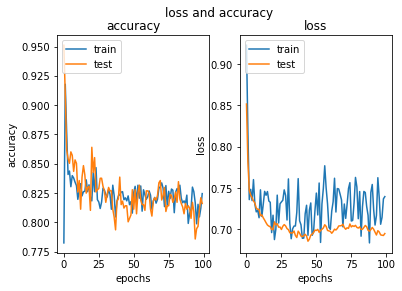

train metrics: 

accuracy: 82.2512 % 

balanced accuracy: 76.6615 %
sensitivity: 0.7047
specificity: 0.8285 

confusion matrix: 
[[2416  500]
 [  44  105]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

test metrics: 

accuracy: 81.6047 % 

balanced accuracy: 73.2551 %
sensitivity: 0.6400
specificity: 0.8251 

confusion matrix: 
[[802 170]
 [ 18  32]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



In [16]:
# Actual model

def train_and_predict(model, training_data, training_labels, 
                      testing_data, testing_labels, epochs=5, 
                      class_weight=10, verbose=0, plot=True):
    """
    This function trains a given neural network model based on training data and training labels. It then predicts classes on
    training and testing data. 
    It is possible to adjust for how many epochs the model is trained and how to weight the sparse class.
    
    INPUT:
    
    model:        model architecture defined before calling this function
    class_weight:  errors on the stroke class should be weighted heavier then the non-stroke class. 
                  The value defines how much more this loss is weighted. loss_weight=10 means a ratio of 1 to 10.
                  For some reason
    verbose:      0: no text per epoch
                  1: text for each epoch
    plot:         True: show accuracy and loss over epochs in figure
                  False: no plot
                  
    OUTPUT: 
    
    predictions_train: vector of training predictions
    predictions_test:  vector of test predictions
    history:           dict containing measures over epochs, including loss, accuracy, TP, FP, TN, FN, for train and test data.
                       print history.history for all measures and their keys.
    
    """
   
    # Compile the layers of the model defined earlier. Use the binary cross entropy function as the loss function as we only
    # have 2 output classes and use accuracy as the metric
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])
    
    # set warnings off (annoying bug in tensorflow)
    tf.get_logger().setLevel('ERROR')
    # Train the model for a number of epochs
    history = model.fit(training_data, training_labels, epochs=epochs, 
                        validation_data=(testing_data, testing_labels),
                        class_weight=[{0: 1., 1: class_weight}],
                        #sample_weight=[None],
                        verbose=verbose
                       )
    # set warnings on again 
    tf.get_logger().setLevel('INFO')

    # Predict the classes of the training data
    predictions_train = model.predict(training_data) >= 0.5
    
    # Predict the classes on the testing data
    predictions_test = model.predict(testing_data) >= 0.5
    
    # Plot the loss and accuracy over epochs.
    if plot:
        fig, axs = plt.subplots(1, 2)
        fig.suptitle('loss and accuracy')
    
        axs[0].plot(history.history['accuracy'])
        axs[0].plot(history.history['val_accuracy'])
        axs[0].legend(['train', 'test'], loc='upper left')
        axs[0].set_title('accuracy')
        axs[0].set_ylabel('accuracy')
        axs[0].set_xlabel('epochs')


        # Plot the loss over epochs
        axs[1].plot(history.history['loss'])
        axs[1].plot(history.history['val_loss'])
        axs[1].set_title('loss')
        axs[1].set_xlabel('epochs')
        axs[1].set_ylabel('loss')
        axs[1].legend(['train', 'test'], loc='upper left')

    
    plt.show()

    return predictions_train, predictions_test, history



In [ ]:

def get_model(train_data, hidden_layers=1, nodes=[20], activation='relu', dropout=False, dropout_rate=[]):
    """
    creates a model with layers based on the input parameters. Dropout possible.
    
    INPUT:
    
    train_data:      training dataset, used to define input layer's shape
    hidden_layers:   number of hidden layers
    nodes:           list, number of nodes for each layer
    activation:      activation function for hidden layers
    dropout:         boolean, if dropout is used
    dropout_rate:    list, rate of dropout if dropout is used. (empty if no dropout used)
    
    OUTPUT:
    model:           full sequential model, to be compiled in function train_and_predict()

    """
    assert len(nodes) == hidden_layers, 'length of list of nodes should be same as defined number of hidden layers'
    
    # Get the amount of input features for the nodes in the first layer
    input_shape = np.shape(train_data)[1]

    # define initialization of all weights in the model
    initializer = initializers.RandomNormal(mean=0.0, stddev=0.2, seed=12345)
    
    # Create the model
    model = models.Sequential()

    # First layer with input nodes equal to features
    model.add(Input(shape=(input_shape)))

    # loop over number of hidden layers to create each.
    for i in range(hidden_layers):
        
        # optionally add dropout layer
        if dropout == True:
            assert len(dropout_rate) == hidden_layers, 'dropout_rate should be defined for each layer'
            model.add(layers.Dropout(0.2))
            
        # add layer with specified number of nodes and activation function.
        model.add(layers.Dense(nodes[i], activation=activation, kernel_initializer=initializer))

    # Output layer with 1 node (only 1 output class, 0 or 1 for stroke) and sigmoid activation function
    model.add(layers.Dense(1, 'sigmoid'))

    return model




### Model without cross-validation

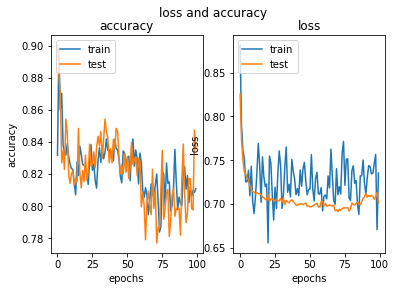

train metrics: 

accuracy: 83.9804 % 

balanced accuracy: 75.9782 %
sensitivity: 0.6711
specificity: 0.8484 

confusion matrix: 
[[2474  442]
 [  49  100]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

test metrics: 

accuracy: 83.5616 % 

balanced accuracy: 71.4383 %
sensitivity: 0.5800
specificity: 0.8488 

confusion matrix: 
[[825 147]
 [ 21  29]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



In [46]:
model = get_model(train_data, hidden_layers=2, nodes=[25, 15], dropout=True, dropout_rate=[0.1, 0.1])

# Train and predict
predictions_train, predictions_test, history = train_and_predict(model, train_data, 
                                                        train_labels, test_data, test_labels,
                                                        class_weight = 10, plot=True,
                                                        epochs=100, verbose=0)

# Print metrics
print('train metrics: \n')
accuracy_train, balanced_accuracy_train = get_metrics(train_labels, predictions_train, verbose=True)

print('test metrics: \n')
accuracy_test, balanced_accuracy_test = get_metrics(test_labels, predictions_test, verbose=True)

### Parameter optimization

##### Class weights

The code below performs training and validation of the DNN model using different class weights.
The different output metrics are then plotted as a function of the class weights to evaluate the weighting effect.

In [ ]:
# Test different class weights and plot accuracy and sensitivity

def compare_class_weights(model, train_data, train_labels, val_data, val_labels, class_weights=range(1, 21, 2)):
    
    # initialize metrics
    accuracies_val = []
    sensitivities_val = []
    balanced_accuracies_val = []
    specificities_val = []
    
    # loop over all class weights and train and predict model.
    for i in tqdm(class_weights):

        # Train and predict 
        predictions_train, predictions_val, history = train_and_predict(model, train_data, 
                                                              train_labels, val_data, val_labels,
                                                              epochs=epochs, verbose=0, plot=False,
                                                              class_weight=i)

        # metrics
        accuracy_val, balanced_accuracy_val = get_metrics(val_labels, predictions_val, verbose=False)
        conmat = confusion_matrix(val_labels, predictions_val)
        sensitivity = conmat[1,1] / sum(conmat[1,:])
        specificity = conmat[0,0] / sum(conmat[0,:])

        accuracies_val.append(accuracy_val)
        balanced_accuracies_val.append(balanced_accuracy_val)
        sensitivities_val.append(sensitivity)
        specificities_val.append(specificity)

    ## Plot metrics over  class weights.
    plt.plot(class_weights, accuracies_val)
    plt.plot(class_weights, balanced_accuracies_val)
    plt.plot(class_weights, sensitivities_val)
    plt.plot(class_weights, specificities_val)
    plt.ylim(0, 1)
    plt.title('Effect of class weights on different output metrics in validation data')
    plt.ylabel('proportions')
    plt.xlabel('Relative weight of stroke class')
    plt.legend(['accuracy', 'balanced_accuracy', 'sensitivity', 'specificity'])
    plt.show() 

model = get_model(train_data, hidden_layers=2, nodes=[25, 15], dropout=True, dropout_rate=[0.1, 0.1])
epochs=50

compare_class_weights(model, train_data, train_labels, val_data, val_labels, class_weights=range(1, 21, 2))

 40%|████      | 4/10 [00:27<00:40,  6.78s/it]

In [5]:
# Get the data and clean it
data = prepare_data('healthcare-dataset-stroke-data.csv', one_hot = False, binary = True, normalize = True)

#data.replace({0: -1})
# Split the data into test, training and validation data
train_data, test_data, val_data, train_labels, test_labels, val_labels = split_data(data, split_size=(0.6, 0.2, 0.2))

In [6]:
# Tryout with different oversampling ratios

oversampling_val = []
oversampling_val_bal = []

# Define categorial features
n_features = np.array([True, False, True, True, True, True,True, False, False, True])

print(train_data)

list_data, list_labels, list_ratio = smote_loop(train_data, train_labels, n_features, 0.2, 1.01, 0.2)

for data_res, labels_res in zip(list_data, list_labels):
    
    # Train and predict
    predictions_train, predictions_val, history = train_and_predict(model, data_res, 
                                                          labels_res, val_data, val_labels,
                                                          epochs=30, verbose=0, plot=False,
                                                          class_weight=[{0: 1., 1: 10}])
    
    # metrics
    accuracy_val, balanced_accuracy_val = get_metrics(val_labels, predictions_val, verbose=False)

    oversampling_val.append(accuracy_val)
    oversampling_val_bal.append(balanced_accuracy_val)
    
## Plot metrics over  class weights.

plt.plot(np.linspace(0.2, 1, 5), accuracies_val)
plt.plot(np.linspace(0.2, 1, 5), balanced_accuracies_val)

plt.ylim(0, 1)
plt.title('Effect of class weights on different output metrics in validation data')
plt.ylabel('proportions')
plt.xlabel('Relative weight of stroke class')
plt.legend(['accuracy', 'balanced_accuracy'])
plt.show()  



      gender       age  hypertension  heart_disease  ever_married  \
1921       1  0.034054             0              0             1   
722        1 -1.513840             0              0             0   
4805       0 -0.275525             0              0             1   
4091       0 -0.717780             0              0             0   
1237       0 -0.452427             0              0             1   
...      ...       ...           ...            ...           ...   
2753       0 -1.115810             0              0             0   
1134       1 -1.842878             0              0             0   
2377       0 -0.673555             0              0             1   
1458       0  0.299408             1              0             1   
4196       0 -1.779193             0              0             0   

          work_type  residence_type  avg_glucose_level       bmi  \
1921        Private               0          -0.235872  0.324124   
722        children               0

ValueError: Error when checking input: expected input_1 to have shape (16,) but got array with shape (19,)

### k-fold cross-validation

array([[0., 0.],
       [0., 0.]])

In [42]:
def k_fold_validation(X, y, model, k=5, class_weight=10, epochs=5, to_return=['metrics', 'history']):
    """
    Uses k-fold cross-validation to estimate average training and validation accuracies over different splits.
    Uses all training/validation data and resplits it 5 times into a training and validation set.
    Then performs training and testing of the model and takes average of accuracies over all 5 folds.
    
    input:
    X:              data array containing all features of training and validation data for cross-validation
    y:              labels of X data
    model:          model as returned by the function get_model()
    k:              number of folds for cross-validation
    class_weight:   relative weight of stroke class cost for model training (ratio 1:class_weight)
    epochs:         number of epochs
    to_return:      list with either one or two strings:
                    'metrics': returns all relevant metrics after all epochs are finished, averaged over k splits
                    'history': returns the loss and accuracy of train and validation data after each epoch, 
                               averaged over k splits
    
    output:         optional: metrics, history (both tuples)
                    metrics (7-item tuple): 
                    - avg_acc_train: average accuracy training folds
                    - avg_bal_acc_train, average balanced accuracy training folds
                    - avg_acc_val, average accuracy validation folds
                    - avg_bal_acc_val, average balanced accuracy validation folds
                    - avg_sens, average sensitivity for validation folds
                    - avg_spec, average specificity for validation folds
                    - conmat, confusion matrix of validation fold predictions.
                    
                    history (4-item tuple):
                    - avg_loss_over_epochs: average loss for each epoch training folds
                    - avg_acc_over_epochs, average accuracy for each epoch training folds
                    - avg_loss_over_epochs_val: average loss for each epoch validation folds
                    - avg_acc_over_epochs_val: average accuracy for each epoch validation folds
    
    """
    # ensure that something is returned, also if one of these will not be calculated.
    metrics = None
    history = None
    
    # initialize metrics
    if 'metrics' in to_return:
        accuracies_train = []
        balanced_accuracies_train = []
        accuracies_val = []
        balanced_accuracies_val = []
        sensitivities = []
        specificities = []
        histories = []
        conmats = np.zeros((2,2))
    
    # get object that splits the data in 5 equal stratified folds.
    sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=0)
    # loop over those 5 datasets
    for train_index, test_index in sss.split(X, y):
        x_train, x_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]
        
        # Find the best fitting theta for this training set using the Normal equation
        predictions_train, predictions_val, history = train_and_predict(model, x_train, y_train, 
                                          x_val, y_val, epochs=epochs, 
                                          class_weight=class_weight, verbose=0, plot=False)
        

        if 'history' in to_return:
            # store history of each split
            histories.append(history)
        
        if 'metrics' in to_return:
            # get metrics for this split
            accuracy_train, balanced_accuracy_train = get_metrics(y_train, predictions_train, verbose=False)
            accuracy_val, balanced_accuracy_val = get_metrics(y_val, predictions_val, verbose=False)
            # get confusion matrix to calculate sensitivity and specificity.
            conmat = confusion_matrix(y_val, predictions_val)
            sensitivity = conmat[1,1] / sum(conmat[1,:])
            specificity = conmat[0,0] / sum(conmat[0,:])
            
            # store metrics for this split
            accuracies_train.append(accuracy_train)
            balanced_accuracies_train.append(balanced_accuracy_train)
            accuracies_val.append(accuracy_val)
            balanced_accuracies_val.append(balanced_accuracy_val)
            conmats += np.array(conmat)
            sensitivities.append(sensitivity)
            specificities.append(specificity)
    

    if 'metrics' in to_return:
        # run over all metrics and compute and store their mean over all k splits.
        metrics_all = [accuracies_train, balanced_accuracies_train, accuracies_val, 
                       specificities, balanced_accuracies_val, sensitivities]
        metrics = []
        for metric in metrics_all:
            # compute average metrics over all k splits.
            metrics.append(statistics.mean(metric))
        
        metrics.append(conmats / 5)
        metrics = tuple(metrics)
        

    if 'history' in to_return:
        history_metrics = []
        history_metrics_names = ['loss', 'accuracy', 'val_loss', 'val_accuracy']
        for metric in history_metrics_names:
            # compute average loss and accuracy over all k splits for each epoch
            metric_history = np.zeros(len(history.history[metric]))
        
            # loop over the history dictionaries for each k split.
            for i in histories:
                metric_history = metric_history + np.array(i.history[metric])
                # add up data of each split for the loss and accuracy 
                # training data     
                
            history_metrics.append(metric_history / k)
        history = tuple(history_metrics)
    return metrics, history_metrics
    

# Datasets for k-fold cross-validation.
data = prepare_data('healthcare-dataset-stroke-data.csv')



# get cross-validation data (which will be further split into train and validation data), and test data.
X, test_data, y, test_labels = split_data(data, split_size=(0.8, 0.2))

#create model
model = get_model(X, hidden_layers=2, nodes=[25, 5], dropout=False, dropout_rate=[0.1, 0.1])

# perform 5-fold cross-validation
epochs = 50
metrics, history = k_fold_validation(np.array(X), np.array(y), model, k=5, 
                                     class_weight=10, epochs=epochs, to_return=['metrics','history'])

# unpack tuples
avg_loss_over_epochs, avg_acc_over_epochs, avg_loss_over_epochs_val, avg_acc_over_epochs_val = history
avg_acc_train, avg_bal_acc_train, avg_acc_val, avg_bal_acc_val, avg_sens, avg_spec, conmat = metrics



average accuracy validation data: 85.5012 % 

average balanced accuracy validation data: 87.0437 %
sensitivity: 0.7127
specificity: 0.5550 

confusion matrix: 
[[677.2 100.8]
 [ 17.8  22.2]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



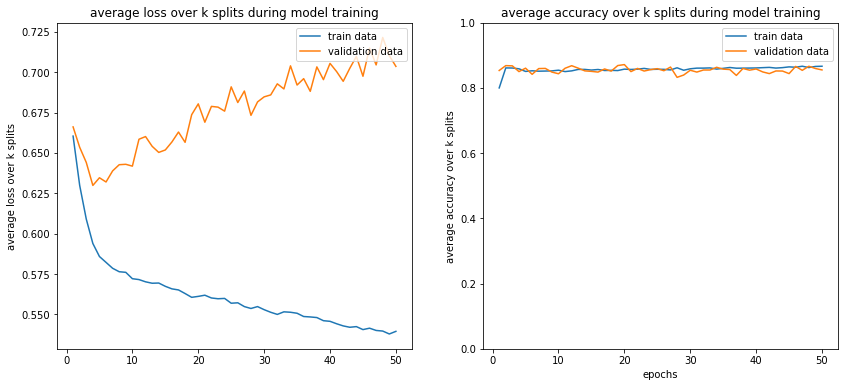

In [43]:
#  print metrics
print(f'average accuracy validation data: {avg_acc_val*100:.4f} % \n')
print(f'average balanced accuracy validation data: {avg_bal_acc_val*100:.4f} %')
print(f'sensitivity: {avg_sens:.4f}')
print(f'specificity: {avg_spec:.4f} \n')
print('confusion matrix: ')
print(f'{conmat} \n')
print('[["True Negative", "False Positive"] \n ["False Negative", "True Positive"]] \n')

# plot the loss and accuracy during learning of the model, averaged over k splits using cross-validation
fig, axs = plt.subplots(1, 2, figsize = (14, 6))
fig.figsize = (10, 8)

# plot average loss of train and validation data for each epoch
epochs = len(avg_loss_over_epochs)
axs[0].plot(range(1, epochs + 1), avg_loss_over_epochs)
axs[0].plot(range(1, epochs + 1), avg_loss_over_epochs_val)
axs[0].set_title('average loss over k splits during model training')
axs[0].set_ylabel('average loss over k splits')
axs[0].legend(['train data', 'validation data'], loc='upper right')

# plot average accuracy of train and validation data for each epoch
axs[1].plot(range(1, epochs + 1), avg_acc_over_epochs)
axs[1].plot(range(1, epochs + 1), avg_acc_over_epochs_val)
axs[1].set_title('average accuracy over k splits during model training')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('average accuracy over k splits')
axs[1].legend(['train data', 'validation data'], loc='upper right')
axs[1].set_ylim([0,1])
plt.show()

### Class weight effects on prediction metrics,  5-fold cross-validation applied.

In [135]:
# Datasets for k-fold cross-validation.
X = prepare_data('healthcare-dataset-stroke-data.csv')

# get cross-validation data (which will be further split into train and val data), and test data.
X, test_data, y, test_labels = split_data(data, split_size=(0.8, 0.2))

avg_accs = []
avg_accs_bal = []
avg_accs_val = []
avg_accs_bal_val = []
avg_sensitivities = []
avg_specificities = []

# do k-fold cross validation for different class weights
for i in tqdm(range(1, 30, 2)):
    metrics, history = k_fold_validation(np.array(X), np.array(y), k=5, 
                                         class_weight=i, epochs=5, to_return=['metrics', 'history'])

    # unpack metrics
    avg_acc_train, avg_bal_acc_train, avg_acc_val, avg_bal_acc_val, avg_sens, avg_spec = metrics

    avg_accs.append(avg_acc_train)
    avg_accs_bal.append(avg_bal_acc_train)
    avg_accs_val.append(avg_acc_val)
    avg_accs_bal_val.append(avg_bal_acc_val)
    avg_sensitivities.append(avg_sens)
    avg_specificities.append(avg_spec)
    
plt.title('Training data')
plt.plot(range(1, 30, 2), avg_accs)
plt.plot(range(1, 30, 2), avg_accs_bal)
plt.ylabel('proportions')
plt.xlabel('Relative weight of stroke class')
plt.legend(['accuracy', 'balanced_accuracy'])
plt.show()

plt.title('Validation data')
plt.plot(range(1, 30, 2), avg_accs_val)
plt.plot(range(1, 30, 2), avg_accs_bal_val)
plt.plot(range(1, 30, 2), avg_sensitivities)
plt.plot(range(1, 30, 2), avg_specificities)
plt.ylabel('proportions')
plt.xlabel('Relative weight of stroke class')
plt.legend(['accuracy', 'balanced_accuracy', 'sensitivity', 'specificity'])
plt.show()

KeyError: 'stroke'